<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/Flower_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section 1

In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 42.4 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [3]:

print("Is CUDA supported by this system?",torch.cuda.is_available())
print("CUDA version: ",torch.version.cuda)


cuda_id = torch.cuda.current_device()
print("ID of current CUDA device:",torch.cuda.current_device())

print("Name of current CUDA device: ",torch.cuda.get_device_name(cuda_id))

Is CUDA supported by this system? True
CUDA version:  11.8
ID of current CUDA device: 0
Name of current CUDA device:  Tesla T4


In [4]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [5]:
NUM_CLIENTS = 10

In [6]:
BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

100%|██████████| 170498071/170498071 [00:01<00:00, 101640880.70it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [7]:
print(type(trainloaders))
print(type(valloaders))
print(type(testloader))

<class 'list'>
<class 'list'>
<class 'torch.utils.data.dataloader.DataLoader'>


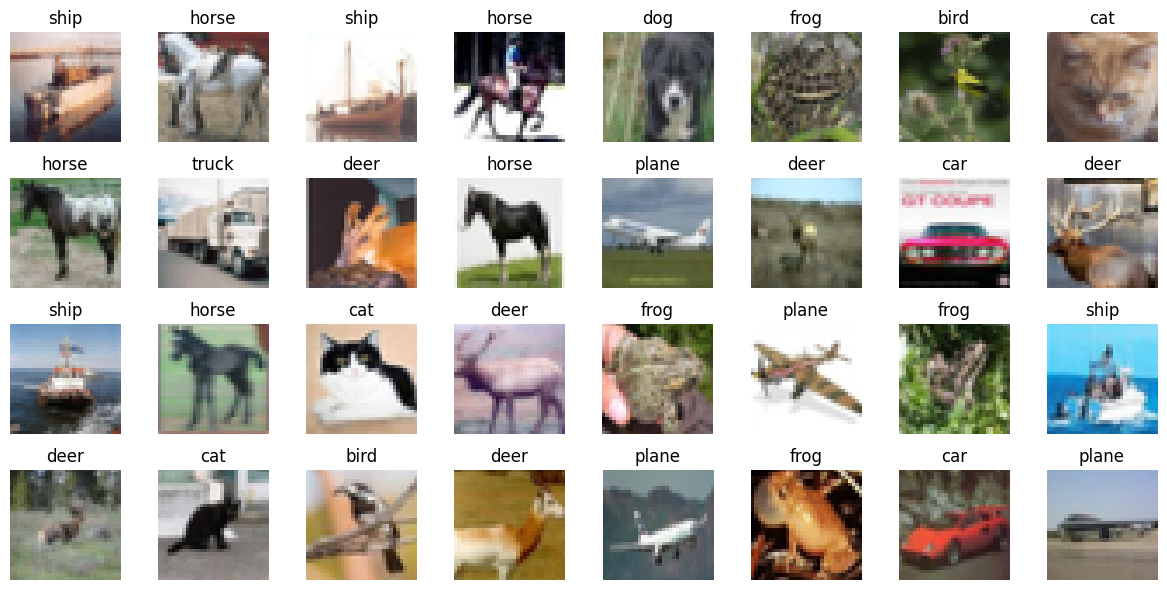

In [8]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [11]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.06436588644981384, accuracy 0.254
Epoch 2: validation loss 0.05750514793395996, accuracy 0.334
Epoch 3: validation loss 0.053866321563720704, accuracy 0.402
Epoch 4: validation loss 0.052608967542648315, accuracy 0.404
Epoch 5: validation loss 0.050375180721282956, accuracy 0.436
Final test set performance:
	loss 0.048920642006397244
	accuracy 0.4403


##FadLearn

In [12]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [14]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client will train and evaluate on their own unique data

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [15]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-05 18:28:18,393 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-07-05 18:28:21,060	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-05 18:28:22,521 | app.py:180 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3932818636.0, 'memory': 7865637275.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3932818636.0, 'memory': 7865637275.0}
INFO flwr 2023-07-05 18:28:22,529 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-05 18:28:22,534 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=17670) 2023-07-05 18:28:25.760346

History (loss, distributed):
	round 1: 0.06244066615104675
	round 2: 0.05366318531036377
	round 3: 0.050813878393173216
	round 4: 0.04964459991455078
	round 5: 0.04813792428970337

In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [17]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-05 18:40:17,809 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-07-05 18:40:23,710	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-05 18:40:25,303 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7859117262.0, 'object_store_memory': 3929558630.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7859117262.0, 'object_store_memory': 3929558630.0}
INFO flwr 2023-07-05 18:40:25,307 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-05 18:40:25,309 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=23622) 2023-07-05 18:40:28.844827

(autoscaler +18m35s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +18m35s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=26334) 2023-07-05 18:46:18.416122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26422) 2023-07-05 18:46:26.580451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26499) 2023-07-05 18:46:36.596453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26571) 2023-07-05 18:46:48.509322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26655) 2023-07-05 18:46:57.286452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26732) 2023-07-05 18:47:06.888728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-07-05 18:47:12,969 | server.py:232 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-07-05 18:4

History (loss, distributed):
	round 1: 0.06207367506027221
	round 2: 0.05439466977119446
	round 3: 0.05161477227210998
	round 4: 0.050364389896392824
	round 5: 0.04796049661636352
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.3136), (2, 0.3788), (3, 0.40279999999999994), (4, 0.41879999999999995), (5, 0.4476)]}

#Section 2
Strategies in Federated Learning

In [1]:
!pip install -q flwr[simulation] torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 53.5 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [3]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

100%|██████████| 170498071/170498071 [00:13<00:00, 12836574.31it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"(Inside FlowerClient class)[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"(Inside FlowerClient class)[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"(Inside FlowerClient class)[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [ ]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

In [9]:
# Create FedAdam strategy
strategy = fl.server.strategy.FedAdagrad(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-07 08:45:30,975 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-07-07 08:45:38,185	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-07 08:45:40,090 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3940931174.0, 'memory': 7881862350.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3940931174.0, 'memory': 7881862350.0}
INFO flwr 2023-07-07 08:45:40,092 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-07 08:45:40,099 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-07-07 08:45:40,104 | server.py:88 | E

(launch_and_fit pid=8998) (Inside FlowerClient class)[Client 3] fit, config: {}
(launch_and_fit pid=8998) Epoch 1: train loss 0.06517007946968079, accuracy 0.2348888888888889


(pid=9076) 2023-07-07 08:45:56.954089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9076) (Inside FlowerClient class)[Client 2] fit, config: {}
(launch_and_fit pid=9076) Epoch 1: train loss 0.06531797349452972, accuracy 0.23


(pid=9145) 2023-07-07 08:46:03.927591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9145) (Inside FlowerClient class)[Client 4] fit, config: {}


DEBUG flwr 2023-07-07 08:46:11,501 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-07-07 08:46:11,516 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 08:46:11,524 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=9145) Epoch 1: train loss 0.06454891711473465, accuracy 0.24022222222222223


(pid=9241) 2023-07-07 08:46:17.507528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9241) (Inside FlowerClient class)[Client 7] evaluate, config: {}


(pid=9308) 2023-07-07 08:46:25.100131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9308) (Inside FlowerClient class)[Client 8] evaluate, config: {}


(pid=9374) 2023-07-07 08:46:31.172257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9374) (Inside FlowerClient class)[Client 0] evaluate, config: {}


DEBUG flwr 2023-07-07 08:46:36,183 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-07-07 08:46:36,189 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 08:46:36,195 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=9462) 2023-07-07 08:46:42.964914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9462) (Inside FlowerClient class)[Client 9] fit, config: {}
(launch_and_fit pid=9462) Epoch 1: train loss 0.833107054233551, accuracy 0.29155555555555557


(pid=9532) 2023-07-07 08:46:52.185306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9532) (Inside FlowerClient class)[Client 3] fit, config: {}
(launch_and_fit pid=9532) Epoch 1: train loss 0.9057071805000305, accuracy 0.29888888888888887


(pid=9611) 2023-07-07 08:46:59.745567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9611) (Inside FlowerClient class)[Client 8] fit, config: {}


DEBUG flwr 2023-07-07 08:47:06,739 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-07-07 08:47:06,769 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=9611) Epoch 1: train loss 0.8791313171386719, accuracy 0.28955555555555557


(pid=9708) 2023-07-07 08:47:12.884456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9708) (Inside FlowerClient class)[Client 9] evaluate, config: {}


(pid=9771) 2023-07-07 08:47:20.054994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9771) (Inside FlowerClient class)[Client 7] evaluate, config: {}


(pid=9841) 2023-07-07 08:47:26.622585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9841) (Inside FlowerClient class)[Client 8] evaluate, config: {}


DEBUG flwr 2023-07-07 08:47:30,575 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-07-07 08:47:30,578 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=9933) 2023-07-07 08:47:38.572456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9933) (Inside FlowerClient class)[Client 9] fit, config: {}
(launch_and_fit pid=9933) Epoch 1: train loss 0.07191070914268494, accuracy 0.17244444444444446


(pid=9999) 2023-07-07 08:47:45.891671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9999) (Inside FlowerClient class)[Client 0] fit, config: {}
(launch_and_fit pid=9999) Epoch 1: train loss 0.07173028588294983, accuracy 0.17155555555555554


(pid=10076) 2023-07-07 08:47:54.958735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10076) (Inside FlowerClient class)[Client 7] fit, config: {}


DEBUG flwr 2023-07-07 08:48:00,542 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-07-07 08:48:00,560 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=10076) Epoch 1: train loss 0.07244326919317245, accuracy 0.15844444444444444


(pid=10176) 2023-07-07 08:48:08.381469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10176) (Inside FlowerClient class)[Client 0] evaluate, config: {}


(pid=10237) 2023-07-07 08:48:14.136010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10237) (Inside FlowerClient class)[Client 7] evaluate, config: {}


(pid=10301) 2023-07-07 08:48:21.525280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10301) (Inside FlowerClient class)[Client 1] evaluate, config: {}


DEBUG flwr 2023-07-07 08:48:25,602 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
INFO flwr 2023-07-07 08:48:25,605 | server.py:147 | FL finished in 165.49539263999986
INFO:flwr:FL finished in 165.49539263999986
INFO flwr 2023-07-07 08:48:25,607 | app.py:218 | app_fit: losses_distributed [(1, 6.117726155598958), (2, 0.164628538608551), (3, 0.2093914442062378)]
INFO:flwr:app_fit: losses_distributed [(1, 6.117726155598958), (2, 0.164628538608551), (3, 0.2093914442062378)]
INFO flwr 2023-07-07 08:48:25,609 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-07 08:48:25,611 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-07-07 08:48:25,612 | app.py:221 | app_fit: losses_centralized []
INFO:flwr:app_fit: losses_centralized []
INFO flwr 2023-07-07 08:48:25,614 | app.py:222 | app_fit: metrics_

History (loss, distributed):
	round 1: 6.117726155598958
	round 2: 0.164628538608551
	round 3: 0.2093914442062378

In [10]:
# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [11]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    evaluate_fn=evaluate,  # Pass the evaluation function
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-07 08:51:18,700 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-07-07 08:51:24,139	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-07 08:51:25,669 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3939970252.0, 'memory': 7879940507.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3939970252.0, 'memory': 7879940507.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-07-07 08:51:25,680 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-07 08:51:25,686 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-07-07 08:51:25,696 | server.py:88 | E

Server-side evaluation loss 0.07375975131988526 / accuracy 0.096


(pid=11404) 2023-07-07 08:51:44.164585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11404) (Inside FlowerClient class)[Client 5] fit, config: {}
(launch_and_fit pid=11404) Epoch 1: train loss 0.06514528393745422, accuracy 0.22933333333333333


(pid=11480) 2023-07-07 08:51:52.483643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11480) (Inside FlowerClient class)[Client 2] fit, config: {}
(launch_and_fit pid=11480) Epoch 1: train loss 0.06532324105501175, accuracy 0.22066666666666668


(pid=11542) 2023-07-07 08:51:59.426825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11542) (Inside FlowerClient class)[Client 0] fit, config: {}


DEBUG flwr 2023-07-07 08:52:06,491 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-07-07 08:52:06,508 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-07-07 08:52:06,676 | server.py:119 | fit progress: (1, 0.06172690033912659, {'accuracy': 0.298}, 28.42061370900001)
INFO:flwr:fit progress: (1, 0.06172690033912659, {'accuracy': 0.298}, 28.42061370900001)
DEBUG flwr 2023-07-07 08:52:06,681 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=11542) Epoch 1: train loss 0.06450339406728745, accuracy 0.2351111111111111
Server-side evaluation loss 0.06172690033912659 / accuracy 0.298


(pid=11646) 2023-07-07 08:52:12.675624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11646) (Inside FlowerClient class)[Client 4] evaluate, config: {}


(pid=11708) 2023-07-07 08:52:20.496090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11708) (Inside FlowerClient class)[Client 0] evaluate, config: {}


(pid=11775) 2023-07-07 08:52:26.025552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11775) (Inside FlowerClient class)[Client 1] evaluate, config: {}


DEBUG flwr 2023-07-07 08:52:30,196 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-07-07 08:52:30,200 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 08:52:30,202 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=11867) 2023-07-07 08:52:38.127819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11867) (Inside FlowerClient class)[Client 9] fit, config: {}
(launch_and_fit pid=11867) Epoch 1: train loss 0.057193536311388016, accuracy 0.32844444444444443


(pid=11932) 2023-07-07 08:52:45.862922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11932) (Inside FlowerClient class)[Client 3] fit, config: {}
(launch_and_fit pid=11932) Epoch 1: train loss 0.05666104704141617, accuracy 0.33311111111111114


(pid=12014) 2023-07-07 08:52:54.803042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12014) (Inside FlowerClient class)[Client 1] fit, config: {}


DEBUG flwr 2023-07-07 08:53:00,795 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-07-07 08:53:01,056 | server.py:119 | fit progress: (2, 0.055778101205825804, {'accuracy': 0.348}, 82.80100527000013)
INFO:flwr:fit progress: (2, 0.055778101205825804, {'accuracy': 0.348}, 82.80100527000013)
DEBUG flwr 2023-07-07 08:53:01,060 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=12014) Epoch 1: train loss 0.05608638748526573, accuracy 0.33444444444444443
Server-side evaluation loss 0.055778101205825804 / accuracy 0.348


(pid=12112) 2023-07-07 08:53:08.485104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12112) (Inside FlowerClient class)[Client 7] evaluate, config: {}


(pid=12172) 2023-07-07 08:53:14.885519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12172) (Inside FlowerClient class)[Client 4] evaluate, config: {}


(pid=12241) 2023-07-07 08:53:22.300986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12241) (Inside FlowerClient class)[Client 6] evaluate, config: {}


DEBUG flwr 2023-07-07 08:53:26,498 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-07-07 08:53:26,503 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=12341) 2023-07-07 08:53:36.276917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12341) (Inside FlowerClient class)[Client 5] fit, config: {}
(launch_and_fit pid=12341) Epoch 1: train loss 0.05410970747470856, accuracy 0.37222222222222223


(pid=12406) 2023-07-07 08:53:43.778873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12406) (Inside FlowerClient class)[Client 4] fit, config: {}
(launch_and_fit pid=12406) Epoch 1: train loss 0.05283806473016739, accuracy 0.3844444444444444


(pid=12481) 2023-07-07 08:53:52.852536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12481) (Inside FlowerClient class)[Client 6] fit, config: {}


DEBUG flwr 2023-07-07 08:53:58,449 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-07-07 08:53:58,632 | server.py:119 | fit progress: (3, 0.05326732897758484, {'accuracy': 0.392}, 140.37703319599996)
INFO:flwr:fit progress: (3, 0.05326732897758484, {'accuracy': 0.392}, 140.37703319599996)
DEBUG flwr 2023-07-07 08:53:58,637 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=12481) Epoch 1: train loss 0.05454986169934273, accuracy 0.3551111111111111
Server-side evaluation loss 0.05326732897758484 / accuracy 0.392


(pid=12583) 2023-07-07 08:54:06.567593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12583) (Inside FlowerClient class)[Client 1] evaluate, config: {}


(pid=12643) 2023-07-07 08:54:12.438546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12643) (Inside FlowerClient class)[Client 3] evaluate, config: {}


(pid=12708) 2023-07-07 08:54:19.960926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12708) (Inside FlowerClient class)[Client 8] evaluate, config: {}


DEBUG flwr 2023-07-07 08:54:24,059 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
INFO flwr 2023-07-07 08:54:24,063 | server.py:147 | FL finished in 165.807491217
INFO:flwr:FL finished in 165.807491217
INFO flwr 2023-07-07 08:54:24,065 | app.py:218 | app_fit: losses_distributed [(1, 0.061518251180648804), (2, 0.053877114295959476), (3, 0.05156103189786276)]
INFO:flwr:app_fit: losses_distributed [(1, 0.061518251180648804), (2, 0.053877114295959476), (3, 0.05156103189786276)]
INFO flwr 2023-07-07 08:54:24,067 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-07 08:54:24,069 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-07-07 08:54:24,071 | app.py:221 | app_fit: losses_centralized [(0, 0.07375975131988526), (1, 0.06172690033912659), (2, 0.055778101205825804), (3, 0.05326732897758484)]


History (loss, distributed):
	round 1: 0.061518251180648804
	round 2: 0.053877114295959476
	round 3: 0.05156103189786276
History (loss, centralized):
	round 0: 0.07375975131988526
	round 1: 0.06172690033912659
	round 2: 0.055778101205825804
	round 3: 0.05326732897758484
History (metrics, centralized):
{'accuracy': [(0, 0.096), (1, 0.298), (2, 0.348), (3, 0.392)]}

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [13]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config

In [14]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-07 09:09:25,257 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-07-07 09:09:32,079	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-07 09:09:34,487 | app.py:180 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7881026766.0, 'object_store_memory': 3940513382.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7881026766.0, 'object_store_memory': 3940513382.0}
INFO flwr 2023-07-07 09:09:34,498 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-07 09:09:34,511 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-07-07 09:09:34,517 | server.py:88 | E

Server-side evaluation loss 0.07369972705841064 / accuracy 0.112


(pid=16892) 2023-07-07 09:09:41.490075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16892) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=16892) Epoch 1: train loss 0.06449506431818008, accuracy 0.224


(pid=16963) 2023-07-07 09:09:49.936590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16963) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=16963) Epoch 1: train loss 0.0644974634051323, accuracy 0.23044444444444445


(pid=17032) 2023-07-07 09:09:57.079930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17032) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-07-07 09:10:04,404 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-07-07 09:10:04,420 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-07-07 09:10:04,607 | server.py:119 | fit progress: (1, 0.06345939993858338, {'accuracy': 0.248}, 29.637974791000033)
INFO:flwr:fit progress: (1, 0.06345939993858338, {'accuracy': 0.248}, 29.637974791000033)
DEBUG flwr 2023-07-07 09:10:04,611 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=17032) Epoch 1: train loss 0.06440415978431702, accuracy 0.22644444444444445
Server-side evaluation loss 0.06345939993858338 / accuracy 0.248


(pid=17134) 2023-07-07 09:10:10.687597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17134) [Client 5] evaluate, config: {}


(pid=17198) 2023-07-07 09:10:18.423053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17198) [Client 6] evaluate, config: {}


(pid=17267) 2023-07-07 09:10:24.468670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17267) [Client 8] evaluate, config: {}


DEBUG flwr 2023-07-07 09:10:28,561 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-07-07 09:10:28,566 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-07 09:10:28,571 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=17359) 2023-07-07 09:10:36.480744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17359) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=17359) Epoch 1: train loss 0.057492535561323166, accuracy 0.32222222222222224
(launch_and_fit pid=17359) Epoch 2: train loss 0.05232701823115349, accuracy 0.38266666666666665


(pid=17436) 2023-07-07 09:10:47.514815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17436) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=17436) Epoch 1: train loss 0.058237671852111816, accuracy 0.31222222222222223
(launch_and_fit pid=17436) Epoch 2: train loss 0.053372252732515335, accuracy 0.37955555555555553


(pid=17522) 2023-07-07 09:10:56.634144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17522) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=17522) Epoch 1: train loss 0.05775872990489006, accuracy 0.31555555555555553


DEBUG flwr 2023-07-07 09:11:05,439 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-07-07 09:11:05,623 | server.py:119 | fit progress: (2, 0.05414517188072204, {'accuracy': 0.368}, 90.65416262600002)
INFO:flwr:fit progress: (2, 0.05414517188072204, {'accuracy': 0.368}, 90.65416262600002)
DEBUG flwr 2023-07-07 09:11:05,627 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=17522) Epoch 2: train loss 0.05327995866537094, accuracy 0.37466666666666665
Server-side evaluation loss 0.05414517188072204 / accuracy 0.368


(pid=17631) 2023-07-07 09:11:11.545811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17631) [Client 9] evaluate, config: {}


(pid=17698) 2023-07-07 09:11:19.016562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17698) [Client 4] evaluate, config: {}


(pid=17760) 2023-07-07 09:11:25.008032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17760) [Client 8] evaluate, config: {}


DEBUG flwr 2023-07-07 09:11:30,084 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-07-07 09:11:30,090 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=17850) 2023-07-07 09:11:36.763315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17850) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=17850) Epoch 1: train loss 0.0523129403591156, accuracy 0.3824444444444444
(launch_and_fit pid=17850) Epoch 2: train loss 0.04927745461463928, accuracy 0.42644444444444446


(pid=17933) 2023-07-07 09:11:47.713919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17933) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=17933) Epoch 1: train loss 0.050386637449264526, accuracy 0.4086666666666667
(launch_and_fit pid=17933) Epoch 2: train loss 0.04761152341961861, accuracy 0.44866666666666666


(pid=18015) 2023-07-07 09:11:57.180647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18015) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=18015) Epoch 1: train loss 0.051983918994665146, accuracy 0.39155555555555555


DEBUG flwr 2023-07-07 09:12:06,325 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-07-07 09:12:06,512 | server.py:119 | fit progress: (3, 0.04968363356590271, {'accuracy': 0.428}, 151.54333692399996)
INFO:flwr:fit progress: (3, 0.04968363356590271, {'accuracy': 0.428}, 151.54333692399996)
DEBUG flwr 2023-07-07 09:12:06,517 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=18015) Epoch 2: train loss 0.04903721809387207, accuracy 0.428
Server-side evaluation loss 0.04968363356590271 / accuracy 0.428


(pid=18122) 2023-07-07 09:12:13.744769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18122) [Client 5] evaluate, config: {}


(pid=18195) 2023-07-07 09:12:20.684762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18195) [Client 3] evaluate, config: {}


(pid=18257) 2023-07-07 09:12:27.241779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18257) [Client 7] evaluate, config: {}


DEBUG flwr 2023-07-07 09:12:32,917 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
INFO flwr 2023-07-07 09:12:32,922 | server.py:147 | FL finished in 177.9535426059997
INFO:flwr:FL finished in 177.9535426059997
INFO flwr 2023-07-07 09:12:32,924 | app.py:218 | app_fit: losses_distributed [(1, 0.06238649066289267), (2, 0.052754376967748005), (3, 0.04783138751983643)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06238649066289267), (2, 0.052754376967748005), (3, 0.04783138751983643)]
INFO flwr 2023-07-07 09:12:32,926 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-07 09:12:32,928 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-07-07 09:12:32,930 | app.py:221 | app_fit: losses_centralized [(0, 0.07369972705841064), (1, 0.06345939993858338), (2, 0.05414517188072204), (3, 0.049683633565902

History (loss, distributed):
	round 1: 0.06238649066289267
	round 2: 0.052754376967748005
	round 3: 0.04783138751983643
History (loss, centralized):
	round 0: 0.07369972705841064
	round 1: 0.06345939993858338
	round 2: 0.05414517188072204
	round 3: 0.04968363356590271
History (metrics, centralized):
{'accuracy': [(0, 0.112), (1, 0.248), (2, 0.368), (3, 0.428)]}

In [33]:
NUM_CLIENTS = 1000

trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": 3,
    }
    return config


strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.025,  # Train on 25 clients (each round)
    fraction_evaluate=0.05,  # Evaluate on 50 clients (each round)
    min_fit_clients=20,
    min_evaluate_clients=40,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    on_fit_config_fn=fit_config,
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-05 19:16:17,678 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-07-05 19:16:23,981	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-05 19:16:25,622 | app.py:180 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3928750080.0, 'memory': 7857500160.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3928750080.0, 'memory': 7857500160.0, 'CPU': 2.0}
INFO flwr 2023-07-05 19:16:25,635 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-05 19:16:25,646 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-07-05 19:16:25,657 | server.py:88 | E

(launch_and_fit pid=39368) [Client 975, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39368) Epoch 1: train loss 0.10148891806602478, accuracy 0.2222222222222222
(launch_and_fit pid=39368) Epoch 2: train loss 0.10080547630786896, accuracy 0.2222222222222222
(launch_and_fit pid=39368) Epoch 3: train loss 0.10026480257511139, accuracy 0.2222222222222222


(pid=39432) 2023-07-05 19:16:44.400202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39432) [Client 661, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39432) Epoch 1: train loss 0.10222543030977249, accuracy 0.06666666666666667
(launch_and_fit pid=39432) Epoch 2: train loss 0.10168001800775528, accuracy 0.15555555555555556
(launch_and_fit pid=39432) Epoch 3: train loss 0.10106199234724045, accuracy 0.15555555555555556


(pid=39502) 2023-07-05 19:16:52.561955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39502) [Client 353, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39502) Epoch 3: train loss 0.10043163597583771, accuracy 0.2222222222222222 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(pid=39570) 2023-07-05 19:16:59.719763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39570) [Client 340, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39570) Epoch 1: train loss 0.10142423957586288, accuracy 0.15555555555555556
(launch_and_fit pid=39570) Epoch 2: train loss 0.10028108209371567, accuracy 0.24444444444444444
(launch_and_fit pid=39570) Epoch 3: train loss 0.09930172562599182, accuracy 0.3111111111111111


(pid=39644) 2023-07-05 19:17:08.392376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39644) [Client 623, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39644) Epoch 3: train loss 0.10164009034633636, accuracy 0.15555555555555556 [repeated 3x across cluster]


(pid=39713) 2023-07-05 19:17:16.796798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39713) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39713) Epoch 1: train loss 0.1025598794221878, accuracy 0.06666666666666667
(launch_and_fit pid=39713) Epoch 2: train loss 0.10109762102365494, accuracy 0.13333333333333333
(launch_and_fit pid=39713) Epoch 3: train loss 0.10155630111694336, accuracy 0.2222222222222222


(pid=39792) 2023-07-05 19:17:24.643771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39792) [Client 768, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39792) Epoch 1: train loss 0.10249247401952744, accuracy 0.044444444444444446
(launch_and_fit pid=39792) Epoch 2: train loss 0.10227762162685394, accuracy 0.1111111111111111
(launch_and_fit pid=39792) Epoch 3: train loss 0.10157787799835205, accuracy 0.15555555555555556


(pid=39856) 2023-07-05 19:17:34.471798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39856) [Client 386, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39856) Epoch 1: train loss 0.10206430405378342, accuracy 0.13333333333333333
(launch_and_fit pid=39856) Epoch 2: train loss 0.10176046192646027, accuracy 0.2
(launch_and_fit pid=39856) Epoch 3: train loss 0.10135703533887863, accuracy 0.15555555555555556


(pid=39939) 2023-07-05 19:17:41.039095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39939) [Client 304, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=39939) Epoch 1: train loss 0.1010710820555687, accuracy 0.26666666666666666
(launch_and_fit pid=39939) Epoch 2: train loss 0.10031657665967941, accuracy 0.28888888888888886
(launch_and_fit pid=39939) Epoch 3: train loss 0.09952954202890396, accuracy 0.28888888888888886


(pid=40009) 2023-07-05 19:17:50.549144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40009) [Client 107, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40009) Epoch 1: train loss 0.10207024961709976, accuracy 0.2
(launch_and_fit pid=40009) Epoch 2: train loss 0.10076665133237839, accuracy 0.2
(launch_and_fit pid=40009) Epoch 3: train loss 0.09944335371255875, accuracy 0.2222222222222222


(pid=40087) 2023-07-05 19:17:57.050227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40087) [Client 82, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40087) Epoch 1: train loss 0.10327763110399246, accuracy 0.044444444444444446
(launch_and_fit pid=40087) Epoch 2: train loss 0.10258666425943375, accuracy 0.1111111111111111
(launch_and_fit pid=40087) Epoch 3: train loss 0.10177913308143616, accuracy 0.1111111111111111


(pid=40155) 2023-07-05 19:18:08.011793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40155) [Client 899, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40155) Epoch 1: train loss 0.10116657614707947, accuracy 0.13333333333333333
(launch_and_fit pid=40155) Epoch 2: train loss 0.10026580095291138, accuracy 0.24444444444444444
(launch_and_fit pid=40155) Epoch 3: train loss 0.09958706051111221, accuracy 0.17777777777777778


(pid=40239) 2023-07-05 19:18:15.285099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40239) [Client 573, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40239) Epoch 1: train loss 0.10227391868829727, accuracy 0.1111111111111111
(launch_and_fit pid=40239) Epoch 2: train loss 0.10123490542173386, accuracy 0.15555555555555556
(launch_and_fit pid=40239) Epoch 3: train loss 0.10131917893886566, accuracy 0.13333333333333333


(pid=40316) 2023-07-05 19:18:23.980520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40316) [Client 210, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40316) Epoch 1: train loss 0.10139122605323792, accuracy 0.1111111111111111
(launch_and_fit pid=40316) Epoch 2: train loss 0.10076311230659485, accuracy 0.2222222222222222
(launch_and_fit pid=40316) Epoch 3: train loss 0.10036174207925797, accuracy 0.24444444444444444


(pid=40379) 2023-07-05 19:18:31.525344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40379) [Client 947, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40379) Epoch 1: train loss 0.10265848785638809, accuracy 0.1111111111111111
(launch_and_fit pid=40379) Epoch 2: train loss 0.10208556801080704, accuracy 0.1111111111111111
(launch_and_fit pid=40379) Epoch 3: train loss 0.10151521861553192, accuracy 0.13333333333333333


(pid=40456) 2023-07-05 19:18:39.910152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40456) [Client 159, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40456) Epoch 1: train loss 0.10307484120130539, accuracy 0.06666666666666667
(launch_and_fit pid=40456) Epoch 2: train loss 0.10222211480140686, accuracy 0.13333333333333333
(launch_and_fit pid=40456) Epoch 3: train loss 0.10186461359262466, accuracy 0.1111111111111111


(pid=40525) 2023-07-05 19:18:48.731296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40525) [Client 883, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40525) Epoch 1: train loss 0.10340619832277298, accuracy 0.06666666666666667
(launch_and_fit pid=40525) Epoch 2: train loss 0.1025184690952301, accuracy 0.1111111111111111
(launch_and_fit pid=40525) Epoch 3: train loss 0.1016390323638916, accuracy 0.17777777777777778


(pid=40601) 2023-07-05 19:18:55.881643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40601) [Client 360, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40601) Epoch 3: train loss 0.1014387384057045, accuracy 0.2222222222222222 [repeated 3x across cluster]


(pid=40670) 2023-07-05 19:19:05.747805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40670) [Client 603, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40670) Epoch 1: train loss 0.10309413820505142, accuracy 0.13333333333333333
(launch_and_fit pid=40670) Epoch 2: train loss 0.1021149754524231, accuracy 0.13333333333333333
(launch_and_fit pid=40670) Epoch 3: train loss 0.10160719603300095, accuracy 0.13333333333333333


(pid=40752) 2023-07-05 19:19:12.503156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40752) [Client 614, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40752) Epoch 1: train loss 0.10336426645517349, accuracy 0.08888888888888889
(launch_and_fit pid=40752) Epoch 2: train loss 0.10240697860717773, accuracy 0.1111111111111111
(launch_and_fit pid=40752) Epoch 3: train loss 0.10253948718309402, accuracy 0.1111111111111111


(pid=40820) 2023-07-05 19:19:20.446292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40820) [Client 115, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40820) Epoch 1: train loss 0.10194100439548492, accuracy 0.08888888888888889
(launch_and_fit pid=40820) Epoch 2: train loss 0.10153809934854507, accuracy 0.15555555555555556
(launch_and_fit pid=40820) Epoch 3: train loss 0.100630022585392, accuracy 0.24444444444444444


(pid=40894) 2023-07-05 19:19:26.395586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40894) [Client 89, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40894) Epoch 1: train loss 0.10202738642692566, accuracy 0.2222222222222222
(launch_and_fit pid=40894) Epoch 2: train loss 0.10142473876476288, accuracy 0.2
(launch_and_fit pid=40894) Epoch 3: train loss 0.10081159323453903, accuracy 0.2


(pid=40959) 2023-07-05 19:19:34.204761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40959) [Client 886, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=40959) Epoch 1: train loss 0.10300111025571823, accuracy 0.06666666666666667
(launch_and_fit pid=40959) Epoch 2: train loss 0.10203556716442108, accuracy 0.17777777777777778
(launch_and_fit pid=40959) Epoch 3: train loss 0.10166814923286438, accuracy 0.17777777777777778


(pid=41032) 2023-07-05 19:19:40.718760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=41032) [Client 602, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(launch_and_fit pid=41032) Epoch 1: train loss 0.10343729704618454, accuracy 0.022222222222222223
(launch_and_fit pid=41032) Epoch 2: train loss 0.10185083001852036, accuracy 0.044444444444444446
(launch_and_fit pid=41032) Epoch 3: train loss 0.1011446863412857, accuracy 0.15555555555555556


(pid=41097) 2023-07-05 19:19:48.530825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=41097) [Client 312, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}


DEBUG flwr 2023-07-05 19:19:53,269 | server.py:232 | fit_round 1 received 25 results and 0 failures
DEBUG:flwr:fit_round 1 received 25 results and 0 failures
WARNING flwr 2023-07-05 19:19:53,330 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-07-05 19:19:53,337 | server.py:168 | evaluate_round 1: strategy sampled 50 clients (out of 1000)
DEBUG:flwr:evaluate_round 1: strategy sampled 50 clients (out of 1000)


(launch_and_fit pid=41097) Epoch 1: train loss 0.10315326601266861, accuracy 0.06666666666666667
(launch_and_fit pid=41097) Epoch 2: train loss 0.10252505540847778, accuracy 0.08888888888888889
(launch_and_fit pid=41097) Epoch 3: train loss 0.10251840204000473, accuracy 0.08888888888888889


(pid=41216) 2023-07-05 19:20:05.406530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41216) [Client 235] evaluate, config: {}


(pid=41284) 2023-07-05 19:20:12.150955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41284) [Client 515] evaluate, config: {}


(pid=41350) 2023-07-05 19:20:21.610921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41350) [Client 327] evaluate, config: {}


(pid=41425) 2023-07-05 19:20:28.151958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41425) [Client 77] evaluate, config: {}


(pid=41495) 2023-07-05 19:20:37.259793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41495) [Client 420] evaluate, config: {}


(pid=41566) 2023-07-05 19:20:43.822983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41566) [Client 152] evaluate, config: {}


(pid=41632) 2023-07-05 19:20:52.613442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41632) [Client 12] evaluate, config: {}


(pid=41703) 2023-07-05 19:20:59.322378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41703) [Client 738] evaluate, config: {}


(pid=41774) 2023-07-05 19:21:07.831274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41774) [Client 390] evaluate, config: {}


(pid=41840) 2023-07-05 19:21:15.226662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41840) [Client 450] evaluate, config: {}


(pid=41915) 2023-07-05 19:21:23.761378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41915) [Client 206] evaluate, config: {}


(pid=41981) 2023-07-05 19:21:30.896048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41981) [Client 976] evaluate, config: {}


(pid=42056) 2023-07-05 19:21:39.584438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42056) [Client 797] evaluate, config: {}


(pid=42122) 2023-07-05 19:21:47.562940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42122) [Client 991] evaluate, config: {}


(pid=42206) 2023-07-05 19:21:57.083171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42206) [Client 742] evaluate, config: {}


(pid=42268) 2023-07-05 19:22:06.979674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42268) [Client 39] evaluate, config: {}


(pid=42349) 2023-07-05 19:22:13.743885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42349) [Client 310] evaluate, config: {}


(pid=42413) 2023-07-05 19:22:23.294747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42413) [Client 565] evaluate, config: {}


(pid=42488) 2023-07-05 19:22:29.857726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42488) [Client 895] evaluate, config: {}


(pid=42561) 2023-07-05 19:22:38.851264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42561) [Client 177] evaluate, config: {}


(pid=42631) 2023-07-05 19:22:45.605460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42631) [Client 116] evaluate, config: {}


(pid=42700) 2023-07-05 19:22:54.117329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42700) [Client 530] evaluate, config: {}


(pid=42766) 2023-07-05 19:23:01.031031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42766) [Client 219] evaluate, config: {}


(pid=42843) 2023-07-05 19:23:09.803157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42843) [Client 639] evaluate, config: {}


(pid=42907) 2023-07-05 19:23:16.861579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42907) [Client 615] evaluate, config: {}


(pid=42980) 2023-07-05 19:23:25.716838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42980) [Client 163] evaluate, config: {}


(pid=43041) 2023-07-05 19:23:34.277527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43041) [Client 348] evaluate, config: {}


(pid=43119) 2023-07-05 19:23:41.878466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43119) [Client 281] evaluate, config: {}


(pid=43184) 2023-07-05 19:23:51.832807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43184) [Client 690] evaluate, config: {}


(pid=43257) 2023-07-05 19:23:58.422548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43257) [Client 259] evaluate, config: {}


(pid=43323) 2023-07-05 19:24:07.929437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43323) [Client 643] evaluate, config: {}


(pid=43396) 2023-07-05 19:24:14.826878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43396) [Client 403] evaluate, config: {}


(pid=43465) 2023-07-05 19:24:23.934577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43465) [Client 898] evaluate, config: {}


(pid=43533) 2023-07-05 19:24:30.870246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43533) [Client 937] evaluate, config: {}


(pid=43608) 2023-07-05 19:24:39.651865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43608) [Client 79] evaluate, config: {}


(pid=43672) 2023-07-05 19:24:46.520698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43672) [Client 998] evaluate, config: {}


(pid=43745) 2023-07-05 19:24:55.245279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43745) [Client 104] evaluate, config: {}


(pid=43809) 2023-07-05 19:25:03.215844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43809) [Client 812] evaluate, config: {}


(pid=43884) 2023-07-05 19:25:11.420691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43884) [Client 496] evaluate, config: {}


(pid=43949) 2023-07-05 19:25:21.199229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43949) [Client 542] evaluate, config: {}


(pid=44022) 2023-07-05 19:25:28.161676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44022) [Client 830] evaluate, config: {}


(pid=44096) 2023-07-05 19:25:40.189131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44096) [Client 130] evaluate, config: {}


(pid=44173) 2023-07-05 19:25:47.015961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44173) [Client 222] evaluate, config: {}


(pid=44242) 2023-07-05 19:25:56.334780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44242) [Client 859] evaluate, config: {}


(pid=44312) 2023-07-05 19:26:03.282066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44312) [Client 704] evaluate, config: {}


(pid=44386) 2023-07-05 19:26:11.132049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44386) [Client 306] evaluate, config: {}


(pid=44447) 2023-07-05 19:26:17.201793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44447) [Client 186] evaluate, config: {}


(pid=44513) 2023-07-05 19:26:26.063789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44513) [Client 533] evaluate, config: {}


(pid=44582) 2023-07-05 19:26:32.168774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44582) [Client 910] evaluate, config: {}


(pid=44648) 2023-07-05 19:26:40.384488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-07-05 19:26:44,331 | server.py:182 | evaluate_round 1 received 50 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 50 results and 0 failures
WARNING flwr 2023-07-05 19:26:44,335 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-05 19:26:44,337 | server.py:218 | fit_round 2: strategy sampled 25 clients (out of 1000)
DEBUG:flwr:fit_round 2: strategy sampled 25 clients (out of 1000)


(launch_and_evaluate pid=44648) [Client 24] evaluate, config: {}


(pid=44759) 2023-07-05 19:26:56.293625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44759) [Client 58, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=44759) Epoch 1: train loss 0.10210783779621124, accuracy 0.15555555555555556
(launch_and_fit pid=44759) Epoch 2: train loss 0.10127274692058563, accuracy 0.2222222222222222
(launch_and_fit pid=44759) Epoch 3: train loss 0.10056789219379425, accuracy 0.2222222222222222


(pid=44825) 2023-07-05 19:27:03.982904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44825) [Client 887, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=44825) Epoch 1: train loss 0.10276854038238525, accuracy 0.08888888888888889
(launch_and_fit pid=44825) Epoch 2: train loss 0.10191074013710022, accuracy 0.15555555555555556
(launch_and_fit pid=44825) Epoch 3: train loss 0.10067532956600189, accuracy 0.13333333333333333


(pid=44903) 2023-07-05 19:27:12.939955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44903) [Client 319, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=44903) Epoch 1: train loss 0.10190872848033905, accuracy 0.15555555555555556
(launch_and_fit pid=44903) Epoch 2: train loss 0.10035186260938644, accuracy 0.2222222222222222
(launch_and_fit pid=44903) Epoch 3: train loss 0.09955866634845734, accuracy 0.2222222222222222


(pid=44969) 2023-07-05 19:27:21.375524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44969) [Client 226, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=44969) Epoch 1: train loss 0.10244034975767136, accuracy 0.1111111111111111
(launch_and_fit pid=44969) Epoch 2: train loss 0.1019110307097435, accuracy 0.15555555555555556
(launch_and_fit pid=44969) Epoch 3: train loss 0.10089991241693497, accuracy 0.15555555555555556


(pid=45044) 2023-07-05 19:27:29.904275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45044) [Client 273, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45044) Epoch 2: train loss 0.10031738877296448, accuracy 0.26666666666666666 [repeated 2x across cluster]


(pid=45118) 2023-07-05 19:27:40.166705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45118) [Client 977, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45044) [Client 977, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45118) Epoch 1: train loss 0.10136792808771133, accuracy 0.2
(launch_and_fit pid=45118) Epoch 2: train loss 0.10033714026212692, accuracy 0.28888888888888886


(pid=45198) 2023-07-05 19:27:47.241713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45118) Epoch 3: train loss 0.09920872002840042, accuracy 0.28888888888888886
(launch_and_fit pid=45198) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45198) Epoch 1: train loss 0.10235913097858429, accuracy 0.2
(launch_and_fit pid=45198) Epoch 2: train loss 0.10152550786733627, accuracy 0.2222222222222222
(launch_and_fit pid=45198) Epoch 3: train loss 0.09970781952142715, accuracy 0.2


(pid=45267) 2023-07-05 19:27:56.799203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45267) [Client 344, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45267) Epoch 1: train loss 0.10287296026945114, accuracy 0.08888888888888889
(launch_and_fit pid=45267) Epoch 2: train loss 0.10217287391424179, accuracy 0.08888888888888889
(launch_and_fit pid=45267) Epoch 3: train loss 0.10106873512268066, accuracy 0.2222222222222222


(pid=45341) 2023-07-05 19:28:03.643413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45341) [Client 83, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45341) Epoch 1: train loss 0.10255797207355499, accuracy 0.06666666666666667


(pid=45418) 2023-07-05 19:28:12.753735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45341) Epoch 2: train loss 0.10174879431724548, accuracy 0.17777777777777778
(launch_and_fit pid=45341) Epoch 3: train loss 0.10071852058172226, accuracy 0.17777777777777778
(launch_and_fit pid=45418) [Client 246, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45418) Epoch 1: train loss 0.10171616822481155, accuracy 0.13333333333333333
(launch_and_fit pid=45418) Epoch 2: train loss 0.10114358365535736, accuracy 0.15555555555555556
(launch_and_fit pid=45418) Epoch 3: train loss 0.09968563914299011, accuracy 0.15555555555555556


(pid=45484) 2023-07-05 19:28:20.047085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45484) [Client 122, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45484) Epoch 1: train loss 0.10146450996398926, accuracy 0.15555555555555556
(launch_and_fit pid=45484) Epoch 2: train loss 0.10097584128379822, accuracy 0.2
(launch_and_fit pid=45484) Epoch 3: train loss 0.10045946389436722, accuracy 0.2


(pid=45565) 2023-07-05 19:28:29.292841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45565) [Client 956, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45565) Epoch 1: train loss 0.10198775678873062, accuracy 0.13333333333333333
(launch_and_fit pid=45565) Epoch 2: train loss 0.10142968595027924, accuracy 0.13333333333333333
(launch_and_fit pid=45565) Epoch 3: train loss 0.10089421272277832, accuracy 0.15555555555555556


(pid=45631) 2023-07-05 19:28:38.556214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45631) [Client 421, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45631) Epoch 1: train loss 0.10232355445623398, accuracy 0.08888888888888889
(launch_and_fit pid=45631) Epoch 2: train loss 0.10155981034040451, accuracy 0.2
(launch_and_fit pid=45631) Epoch 3: train loss 0.10012952238321304, accuracy 0.2222222222222222
(autoscaler +1h1m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=45711) 2023-07-05 19:28:47.487133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45711) [Client 360, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45711) Epoch 1: train loss 0.10214466601610184, accuracy 0.17777777777777778
(launch_and_fit pid=45711) Epoch 2: train loss 0.1012733057141304, accuracy 0.2
(launch_and_fit pid=45711) Epoch 3: train loss 0.09936297684907913, accuracy 0.2222222222222222


(pid=45783) 2023-07-05 19:28:57.377205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45783) [Client 276, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45783) Epoch 1: train loss 0.10190677642822266, accuracy 0.13333333333333333
(launch_and_fit pid=45783) Epoch 2: train loss 0.10165899246931076, accuracy 0.13333333333333333
(launch_and_fit pid=45783) Epoch 3: train loss 0.10079725086688995, accuracy 0.13333333333333333


(pid=45863) 2023-07-05 19:29:04.292821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45863) [Client 650, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45863) Epoch 1: train loss 0.10259564220905304, accuracy 0.08888888888888889
(launch_and_fit pid=45863) Epoch 2: train loss 0.10198347270488739, accuracy 0.13333333333333333
(launch_and_fit pid=45863) Epoch 3: train loss 0.10032431781291962, accuracy 0.15555555555555556


(pid=45941) 2023-07-05 19:29:14.000071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45941) [Client 670, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=45941) Epoch 1: train loss 0.10253798216581345, accuracy 0.08888888888888889
(launch_and_fit pid=45941) Epoch 2: train loss 0.10148192942142487, accuracy 0.17777777777777778
(launch_and_fit pid=45941) Epoch 3: train loss 0.10087726265192032, accuracy 0.17777777777777778


(pid=46016) 2023-07-05 19:29:26.025722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46016) [Client 261, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46016) Epoch 1: train loss 0.10151837021112442, accuracy 0.17777777777777778
(launch_and_fit pid=46016) Epoch 2: train loss 0.10083433985710144, accuracy 0.24444444444444444
(launch_and_fit pid=46016) Epoch 3: train loss 0.09980928897857666, accuracy 0.28888888888888886


(pid=46094) 2023-07-05 19:29:32.919286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46094) [Client 496, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46094) Epoch 1: train loss 0.10029201954603195, accuracy 0.24444444444444444
(launch_and_fit pid=46094) Epoch 2: train loss 0.10041169077157974, accuracy 0.26666666666666666
(launch_and_fit pid=46094) Epoch 3: train loss 0.09860121458768845, accuracy 0.24444444444444444


(pid=46168) 2023-07-05 19:29:42.535842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46168) [Client 798, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46168) Epoch 1: train loss 0.10186033695936203, accuracy 0.15555555555555556
(launch_and_fit pid=46168) Epoch 2: train loss 0.10132285207509995, accuracy 0.15555555555555556
(launch_and_fit pid=46168) Epoch 3: train loss 0.10075008124113083, accuracy 0.15555555555555556


(pid=46238) 2023-07-05 19:29:48.336886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46238) [Client 810, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46238) Epoch 1: train loss 0.10326116532087326, accuracy 0.06666666666666667
(launch_and_fit pid=46238) Epoch 2: train loss 0.10234533995389938, accuracy 0.06666666666666667
(launch_and_fit pid=46238) Epoch 3: train loss 0.10136400163173676, accuracy 0.13333333333333333


(pid=46308) 2023-07-05 19:29:56.395170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46308) [Client 110, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46308) Epoch 1: train loss 0.10308147221803665, accuracy 0.08888888888888889
(launch_and_fit pid=46308) Epoch 2: train loss 0.1019335687160492, accuracy 0.08888888888888889
(launch_and_fit pid=46308) Epoch 3: train loss 0.10047683864831924, accuracy 0.2222222222222222


(pid=46375) 2023-07-05 19:30:02.820516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46375) [Client 976, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46375) Epoch 1: train loss 0.10238207131624222, accuracy 0.08888888888888889
(launch_and_fit pid=46375) Epoch 2: train loss 0.10094157606363297, accuracy 0.2
(launch_and_fit pid=46375) Epoch 3: train loss 0.1000974029302597, accuracy 0.3111111111111111


(pid=46444) 2023-07-05 19:30:10.928026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46444) [Client 445, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(launch_and_fit pid=46444) Epoch 1: train loss 0.10219806432723999, accuracy 0.13333333333333333
(launch_and_fit pid=46444) Epoch 2: train loss 0.10174285620450974, accuracy 0.2
(launch_and_fit pid=46444) Epoch 3: train loss 0.10026323795318604, accuracy 0.17777777777777778


(pid=46512) 2023-07-05 19:30:17.295205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46512) [Client 999, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}


DEBUG flwr 2023-07-05 19:30:22,485 | server.py:232 | fit_round 2 received 25 results and 0 failures
DEBUG:flwr:fit_round 2 received 25 results and 0 failures
DEBUG flwr 2023-07-05 19:30:22,582 | server.py:168 | evaluate_round 2: strategy sampled 50 clients (out of 1000)
DEBUG:flwr:evaluate_round 2: strategy sampled 50 clients (out of 1000)


(launch_and_fit pid=46512) Epoch 1: train loss 0.10146652162075043, accuracy 0.2222222222222222
(launch_and_fit pid=46512) Epoch 2: train loss 0.10012771189212799, accuracy 0.26666666666666666
(launch_and_fit pid=46512) Epoch 3: train loss 0.09712261706590652, accuracy 0.2222222222222222


(pid=46624) 2023-07-05 19:30:33.092977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46624) [Client 385] evaluate, config: {}


(pid=46690) 2023-07-05 19:30:41.871051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46690) [Client 465] evaluate, config: {}


(pid=46759) 2023-07-05 19:30:48.855947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46759) [Client 263] evaluate, config: {}


(pid=46827) 2023-07-05 19:30:57.294848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46827) [Client 79] evaluate, config: {}


(pid=46892) 2023-07-05 19:31:04.622012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46892) [Client 750] evaluate, config: {}


(pid=46967) 2023-07-05 19:31:13.427490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46967) [Client 946] evaluate, config: {}


(pid=47031) 2023-07-05 19:31:22.249934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47031) [Client 542] evaluate, config: {}


(pid=47104) 2023-07-05 19:31:29.848163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47104) [Client 62] evaluate, config: {}


(pid=47168) 2023-07-05 19:31:40.169214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47168) [Client 598] evaluate, config: {}


(pid=47248) 2023-07-05 19:31:47.255836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47248) [Client 442] evaluate, config: {}


(pid=47317) 2023-07-05 19:31:56.608243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47317) [Client 371] evaluate, config: {}


(pid=47389) 2023-07-05 19:32:03.240525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47389) [Client 919] evaluate, config: {}


(pid=47460) 2023-07-05 19:32:12.200694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47460) [Client 937] evaluate, config: {}


(pid=47529) 2023-07-05 19:32:19.325726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47529) [Client 231] evaluate, config: {}


(pid=47597) 2023-07-05 19:32:28.125807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47597) [Client 446] evaluate, config: {}


(pid=47662) 2023-07-05 19:32:35.762856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47662) [Client 409] evaluate, config: {}


(pid=47741) 2023-07-05 19:32:44.525282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47741) [Client 567] evaluate, config: {}


(pid=47805) 2023-07-05 19:32:53.371468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47805) [Client 519] evaluate, config: {}


(pid=47878) 2023-07-05 19:33:04.152093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47878) [Client 361] evaluate, config: {}


(pid=47961) 2023-07-05 19:33:12.746794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47961) [Client 522] evaluate, config: {}


(pid=48030) 2023-07-05 19:33:19.875272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48030) [Client 172] evaluate, config: {}


(pid=48099) 2023-07-05 19:33:28.773130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48099) [Client 677] evaluate, config: {}


(pid=48167) 2023-07-05 19:33:36.793885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48167) [Client 169] evaluate, config: {}


(pid=48242) 2023-07-05 19:33:45.094719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48242) [Client 94] evaluate, config: {}


(pid=48306) 2023-07-05 19:33:54.992746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48306) [Client 954] evaluate, config: {}


(pid=48379) 2023-07-05 19:34:01.926234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48379) [Client 433] evaluate, config: {}


(pid=48448) 2023-07-05 19:34:11.660997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48448) [Client 191] evaluate, config: {}


(pid=48522) 2023-07-05 19:34:18.510929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48522) [Client 537] evaluate, config: {}


(pid=48591) 2023-07-05 19:34:27.832296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48591) [Client 268] evaluate, config: {}


(pid=48660) 2023-07-05 19:34:34.836734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48660) [Client 138] evaluate, config: {}


(pid=48734) 2023-07-05 19:34:43.469168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48734) [Client 118] evaluate, config: {}


(pid=48799) 2023-07-05 19:34:50.734484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48799) [Client 871] evaluate, config: {}


(pid=48872) 2023-07-05 19:34:59.669728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48872) [Client 903] evaluate, config: {}


(pid=48936) 2023-07-05 19:35:08.096076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48936) [Client 991] evaluate, config: {}


(pid=49011) 2023-07-05 19:35:16.117889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49011) [Client 706] evaluate, config: {}


(pid=49079) 2023-07-05 19:35:26.296681: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49079) [Client 560] evaluate, config: {}


(pid=49152) 2023-07-05 19:35:33.244139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49152) [Client 822] evaluate, config: {}


(pid=49223) 2023-07-05 19:35:42.851042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49223) [Client 5] evaluate, config: {}


(pid=49296) 2023-07-05 19:35:49.655270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49296) [Client 743] evaluate, config: {}


(pid=49364) 2023-07-05 19:35:58.626817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49364) [Client 827] evaluate, config: {}


(pid=49433) 2023-07-05 19:36:05.837042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49433) [Client 626] evaluate, config: {}


(pid=49508) 2023-07-05 19:36:14.710914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49508) [Client 460] evaluate, config: {}


(pid=49572) 2023-07-05 19:36:22.158843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49572) [Client 400] evaluate, config: {}


(pid=49647) 2023-07-05 19:36:31.171289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49647) [Client 923] evaluate, config: {}


(pid=49711) 2023-07-05 19:36:40.219872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49711) [Client 397] evaluate, config: {}


(pid=49795) 2023-07-05 19:36:48.675772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49795) [Client 679] evaluate, config: {}


(pid=49859) 2023-07-05 19:36:56.800924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49859) [Client 279] evaluate, config: {}


(pid=49929) 2023-07-05 19:37:03.115378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49929) [Client 302] evaluate, config: {}


(pid=49989) 2023-07-05 19:37:11.049458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49989) [Client 757] evaluate, config: {}


(pid=50059) 2023-07-05 19:37:17.751658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-07-05 19:37:22,160 | server.py:182 | evaluate_round 2 received 50 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 50 results and 0 failures
DEBUG flwr 2023-07-05 19:37:22,165 | server.py:218 | fit_round 3: strategy sampled 25 clients (out of 1000)
DEBUG:flwr:fit_round 3: strategy sampled 25 clients (out of 1000)


(launch_and_evaluate pid=50059) [Client 955] evaluate, config: {}


(pid=50172) 2023-07-05 19:37:34.255579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50172) [Client 940, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50172) Epoch 1: train loss 0.10233590751886368, accuracy 0.06666666666666667
(launch_and_fit pid=50172) Epoch 2: train loss 0.10073793679475784, accuracy 0.15555555555555556
(launch_and_fit pid=50172) Epoch 3: train loss 0.0986524298787117, accuracy 0.17777777777777778


(pid=50239) 2023-07-05 19:37:44.335892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50239) [Client 43, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50239) Epoch 1: train loss 0.10144298523664474, accuracy 0.17777777777777778
(launch_and_fit pid=50239) Epoch 2: train loss 0.10043412446975708, accuracy 0.13333333333333333
(launch_and_fit pid=50239) Epoch 3: train loss 0.09759040921926498, accuracy 0.15555555555555556


(pid=50314) 2023-07-05 19:37:51.261283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50314) [Client 829, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50314) Epoch 1: train loss 0.10165959596633911, accuracy 0.17777777777777778
(launch_and_fit pid=50314) Epoch 2: train loss 0.09942523390054703, accuracy 0.15555555555555556
(launch_and_fit pid=50314) Epoch 3: train loss 0.09920582175254822, accuracy 0.17777777777777778


(pid=50386) 2023-07-05 19:38:00.273254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50386) [Client 87, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50386) Epoch 1: train loss 0.10142135620117188, accuracy 0.13333333333333333
(launch_and_fit pid=50386) Epoch 2: train loss 0.10021919757127762, accuracy 0.24444444444444444
(launch_and_fit pid=50386) Epoch 3: train loss 0.09809833019971848, accuracy 0.2222222222222222


(pid=50457) 2023-07-05 19:38:07.664110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50457) [Client 648, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50457) Epoch 1: train loss 0.1018889844417572, accuracy 0.13333333333333333
(launch_and_fit pid=50457) Epoch 2: train loss 0.10064209997653961, accuracy 0.26666666666666666
(launch_and_fit pid=50457) Epoch 3: train loss 0.09821487218141556, accuracy 0.3333333333333333


(pid=50535) 2023-07-05 19:38:16.926809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50535) [Client 517, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50535) Epoch 1: train loss 0.10172373801469803, accuracy 0.1111111111111111


(pid=50603) 2023-07-05 19:38:25.426122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50535) Epoch 2: train loss 0.0996985211968422, accuracy 0.26666666666666666
(launch_and_fit pid=50535) Epoch 3: train loss 0.09648144990205765, accuracy 0.4222222222222222
(launch_and_fit pid=50603) [Client 215, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50603) Epoch 1: train loss 0.10155802220106125, accuracy 0.2
(launch_and_fit pid=50603) Epoch 2: train loss 0.10066390782594681, accuracy 0.26666666666666666
(launch_and_fit pid=50603) Epoch 3: train loss 0.0988759770989418, accuracy 0.26666666666666666


(pid=50683) 2023-07-05 19:38:33.886916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50683) [Client 338, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50683) Epoch 1: train loss 0.10232053697109222, accuracy 0.13333333333333333
(launch_and_fit pid=50683) Epoch 2: train loss 0.10073640942573547, accuracy 0.2
(launch_and_fit pid=50683) Epoch 3: train loss 0.09790042787790298, accuracy 0.17777777777777778


(pid=50754) 2023-07-05 19:38:44.373587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50754) [Client 607, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50754) Epoch 1: train loss 0.10052521526813507, accuracy 0.24444444444444444
(launch_and_fit pid=50754) Epoch 2: train loss 0.09837301075458527, accuracy 0.2222222222222222
(launch_and_fit pid=50754) Epoch 3: train loss 0.09784016013145447, accuracy 0.2222222222222222


(pid=50832) 2023-07-05 19:38:51.267470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50832) [Client 564, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50832) Epoch 1: train loss 0.1015344187617302, accuracy 0.2222222222222222


(pid=50908) 2023-07-05 19:39:01.066093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50832) Epoch 2: train loss 0.09902182966470718, accuracy 0.24444444444444444
(launch_and_fit pid=50832) Epoch 3: train loss 0.09721893072128296, accuracy 0.24444444444444444
(launch_and_fit pid=50908) [Client 245, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50908) Epoch 1: train loss 0.10123340785503387, accuracy 0.15555555555555556
(launch_and_fit pid=50908) Epoch 2: train loss 0.09950074553489685, accuracy 0.15555555555555556
(launch_and_fit pid=50908) Epoch 3: train loss 0.09929013252258301, accuracy 0.17777777777777778


(pid=50978) 2023-07-05 19:39:08.443568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50978) [Client 936, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=50978) Epoch 1: train loss 0.10254084318876266, accuracy 0.06666666666666667
(launch_and_fit pid=50978) Epoch 2: train loss 0.10036733746528625, accuracy 0.06666666666666667
(launch_and_fit pid=50978) Epoch 3: train loss 0.09817682206630707, accuracy 0.15555555555555556


(pid=51059) 2023-07-05 19:39:17.828043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51059) [Client 568, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51059) Epoch 1: train loss 0.10213032364845276, accuracy 0.1111111111111111
(launch_and_fit pid=51059) Epoch 2: train loss 0.10007119178771973, accuracy 0.15555555555555556
(launch_and_fit pid=51059) Epoch 3: train loss 0.09976476430892944, accuracy 0.2


(pid=51126) 2023-07-05 19:39:26.510364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51126) [Client 856, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51126) Epoch 1: train loss 0.10171891748905182, accuracy 0.2
(launch_and_fit pid=51126) Epoch 2: train loss 0.09985684603452682, accuracy 0.2
(launch_and_fit pid=51126) Epoch 3: train loss 0.09942729026079178, accuracy 0.15555555555555556


(pid=51205) 2023-07-05 19:39:34.779473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51205) [Client 721, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51205) Epoch 1: train loss 0.10040830075740814, accuracy 0.2


(pid=51272) 2023-07-05 19:39:44.992441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51205) Epoch 2: train loss 0.09844227135181427, accuracy 0.24444444444444444
(launch_and_fit pid=51205) Epoch 3: train loss 0.09855631738901138, accuracy 0.2
(launch_and_fit pid=51272) [Client 679, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51272) Epoch 1: train loss 0.10073450207710266, accuracy 0.24444444444444444
(launch_and_fit pid=51272) Epoch 2: train loss 0.097811259329319, accuracy 0.26666666666666666
(launch_and_fit pid=51272) Epoch 3: train loss 0.09594462811946869, accuracy 0.24444444444444444


(pid=51352) 2023-07-05 19:39:51.914584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51352) [Client 129, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51352) Epoch 1: train loss 0.10046296566724777, accuracy 0.3333333333333333
(launch_and_fit pid=51352) Epoch 2: train loss 0.09750977158546448, accuracy 0.3333333333333333
(launch_and_fit pid=51352) Epoch 3: train loss 0.09251721948385239, accuracy 0.35555555555555557


(pid=51424) 2023-07-05 19:40:01.180755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51424) [Client 467, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51424) Epoch 1: train loss 0.10160814225673676, accuracy 0.15555555555555556
(launch_and_fit pid=51424) Epoch 2: train loss 0.09972289949655533, accuracy 0.17777777777777778
(launch_and_fit pid=51424) Epoch 3: train loss 0.09965526312589645, accuracy 0.2222222222222222


(pid=51494) 2023-07-05 19:40:08.535453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51494) [Client 442, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51494) Epoch 1: train loss 0.10169172286987305, accuracy 0.2
(launch_and_fit pid=51494) Epoch 2: train loss 0.10048238933086395, accuracy 0.2222222222222222
(launch_and_fit pid=51494) Epoch 3: train loss 0.09961124509572983, accuracy 0.2


(pid=51573) 2023-07-05 19:40:17.814889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51573) [Client 816, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51573) Epoch 1: train loss 0.10192697495222092, accuracy 0.06666666666666667
(launch_and_fit pid=51573) Epoch 2: train loss 0.1003069058060646, accuracy 0.17777777777777778
(launch_and_fit pid=51573) Epoch 3: train loss 0.10034080594778061, accuracy 0.15555555555555556


(pid=51643) 2023-07-05 19:40:26.801481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51643) [Client 466, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51643) Epoch 1: train loss 0.10048612207174301, accuracy 0.24444444444444444
(launch_and_fit pid=51643) Epoch 2: train loss 0.09938335418701172, accuracy 0.17777777777777778
(launch_and_fit pid=51643) Epoch 3: train loss 0.09707944095134735, accuracy 0.17777777777777778


(pid=51722) 2023-07-05 19:40:34.741018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51722) [Client 615, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51722) Epoch 1: train loss 0.10123074799776077, accuracy 0.2
(launch_and_fit pid=51722) Epoch 2: train loss 0.09859922528266907, accuracy 0.28888888888888886
(launch_and_fit pid=51722) Epoch 3: train loss 0.09627316147089005, accuracy 0.3333333333333333


(pid=51788) 2023-07-05 19:40:42.047697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51788) [Client 618, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51788) Epoch 1: train loss 0.10150020569562912, accuracy 0.15555555555555556
(launch_and_fit pid=51788) Epoch 2: train loss 0.09915275871753693, accuracy 0.2222222222222222
(launch_and_fit pid=51788) Epoch 3: train loss 0.09748498350381851, accuracy 0.26666666666666666


(pid=51861) 2023-07-05 19:40:49.782962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51861) [Client 397, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(launch_and_fit pid=51861) Epoch 1: train loss 0.10176201164722443, accuracy 0.06666666666666667
(launch_and_fit pid=51861) Epoch 2: train loss 0.10061519593000412, accuracy 0.13333333333333333
(launch_and_fit pid=51861) Epoch 3: train loss 0.09733066707849503, accuracy 0.37777777777777777


(pid=51928) 2023-07-05 19:40:56.733416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51928) [Client 286, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}


DEBUG flwr 2023-07-05 19:41:02,662 | server.py:232 | fit_round 3 received 25 results and 0 failures
DEBUG:flwr:fit_round 3 received 25 results and 0 failures
DEBUG flwr 2023-07-05 19:41:02,738 | server.py:168 | evaluate_round 3: strategy sampled 50 clients (out of 1000)
DEBUG:flwr:evaluate_round 3: strategy sampled 50 clients (out of 1000)


(launch_and_fit pid=51928) Epoch 1: train loss 0.10266045480966568, accuracy 0.15555555555555556
(launch_and_fit pid=51928) Epoch 2: train loss 0.10031744837760925, accuracy 0.13333333333333333
(launch_and_fit pid=51928) Epoch 3: train loss 0.09859362989664078, accuracy 0.2


(pid=52041) 2023-07-05 19:41:14.594902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52041) [Client 629] evaluate, config: {}


(pid=52115) 2023-07-05 19:41:22.405440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52115) [Client 297] evaluate, config: {}


(pid=52180) 2023-07-05 19:41:32.234697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52180) [Client 814] evaluate, config: {}


(pid=52252) 2023-07-05 19:41:39.089025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52252) [Client 676] evaluate, config: {}


(pid=52327) 2023-07-05 19:41:48.261744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52327) [Client 516] evaluate, config: {}


(pid=52396) 2023-07-05 19:41:55.223342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52396) [Client 408] evaluate, config: {}


(pid=52464) 2023-07-05 19:42:04.083687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52464) [Client 42] evaluate, config: {}


(pid=52529) 2023-07-05 19:42:11.569217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52529) [Client 179] evaluate, config: {}


(pid=52605) 2023-07-05 19:42:20.492006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52605) [Client 102] evaluate, config: {}


(pid=52672) 2023-07-05 19:42:30.220682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52672) [Client 933] evaluate, config: {}


(pid=52745) 2023-07-05 19:42:37.466790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52745) [Client 71] evaluate, config: {}


(pid=52816) 2023-07-05 19:42:47.463016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52816) [Client 357] evaluate, config: {}


(pid=52888) 2023-07-05 19:42:54.104260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52888) [Client 30] evaluate, config: {}


(pid=52957) 2023-07-05 19:43:03.764455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52957) [Client 365] evaluate, config: {}


(pid=53030) 2023-07-05 19:43:10.776771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53030) [Client 407] evaluate, config: {}


(pid=53100) 2023-07-05 19:43:19.569798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53100) [Client 61] evaluate, config: {}


(pid=53169) 2023-07-05 19:43:27.420620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53169) [Client 833] evaluate, config: {}


(pid=53242) 2023-07-05 19:43:36.166822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53242) [Client 430] evaluate, config: {}


(pid=53306) 2023-07-05 19:43:46.415941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53306) [Client 403] evaluate, config: {}


(pid=53385) 2023-07-05 19:43:53.242957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53385) [Client 278] evaluate, config: {}


(pid=53450) 2023-07-05 19:44:03.982151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53450) [Client 185] evaluate, config: {}


(pid=53535) 2023-07-05 19:44:12.153303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53535) [Client 710] evaluate, config: {}


(pid=53606) 2023-07-05 19:44:21.044489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53606) [Client 530] evaluate, config: {}


(pid=53670) 2023-07-05 19:44:28.992692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53670) [Client 870] evaluate, config: {}


(pid=53747) 2023-07-05 19:44:37.044284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53747) [Client 255] evaluate, config: {}


(pid=53807) 2023-07-05 19:44:46.562345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53807) [Client 573] evaluate, config: {}


(pid=53886) 2023-07-05 19:44:53.622125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53886) [Client 780] evaluate, config: {}


(pid=53951) 2023-07-05 19:45:03.426370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53951) [Client 659] evaluate, config: {}


(pid=54024) 2023-07-05 19:45:10.176284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54024) [Client 454] evaluate, config: {}


(pid=54094) 2023-07-05 19:45:19.609165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54094) [Client 852] evaluate, config: {}


(pid=54167) 2023-07-05 19:45:26.300154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54167) [Client 245] evaluate, config: {}


(pid=54235) 2023-07-05 19:45:35.192614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54235) [Client 318] evaluate, config: {}


(pid=54300) 2023-07-05 19:45:42.309020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54300) [Client 58] evaluate, config: {}


(pid=54375) 2023-07-05 19:45:51.136117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54375) [Client 937] evaluate, config: {}


(pid=54439) 2023-07-05 19:45:58.195815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54439) [Client 80] evaluate, config: {}


(pid=54512) 2023-07-05 19:46:06.891721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54512) [Client 453] evaluate, config: {}


(pid=54576) 2023-07-05 19:46:15.941810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54576) [Client 107] evaluate, config: {}


(pid=54651) 2023-07-05 19:46:23.392373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54651) [Client 32] evaluate, config: {}


(pid=54718) 2023-07-05 19:46:33.586241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54718) [Client 420] evaluate, config: {}


(pid=54795) 2023-07-05 19:46:40.457511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54795) [Client 713] evaluate, config: {}


(pid=54865) 2023-07-05 19:46:49.910141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54865) [Client 533] evaluate, config: {}


(pid=54934) 2023-07-05 19:46:56.725071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54934) [Client 945] evaluate, config: {}


(pid=55002) 2023-07-05 19:47:05.850279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55002) [Client 213] evaluate, config: {}


(pid=55071) 2023-07-05 19:47:12.915925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55071) [Client 351] evaluate, config: {}


(pid=55146) 2023-07-05 19:47:21.584356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55146) [Client 445] evaluate, config: {}


(pid=55210) 2023-07-05 19:47:27.546614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55210) [Client 36] evaluate, config: {}


(pid=55279) 2023-07-05 19:47:35.702417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55279) [Client 794] evaluate, config: {}


(pid=55343) 2023-07-05 19:47:44.559099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55343) [Client 758] evaluate, config: {}


(pid=55422) 2023-07-05 19:47:52.652375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55422) [Client 195] evaluate, config: {}


(pid=55482) 2023-07-05 19:47:58.683587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-07-05 19:48:04,780 | server.py:182 | evaluate_round 3 received 50 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 50 results and 0 failures
INFO flwr 2023-07-05 19:48:04,786 | server.py:147 | FL finished in 1899.112428677
INFO:flwr:FL finished in 1899.112428677
INFO flwr 2023-07-05 19:48:04,790 | app.py:218 | app_fit: losses_distributed [(1, 0.4589632167816161), (2, 0.457819462776184), (3, 0.4475054044723511)]
INFO:flwr:app_fit: losses_distributed [(1, 0.4589632167816161), (2, 0.457819462776184), (3, 0.4475054044723511)]
INFO flwr 2023-07-05 19:48:04,796 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-05 19:48:04,798 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-07-05 19:48:04,805 | app.py:221 | app_fi

(launch_and_evaluate pid=55482) [Client 802] evaluate, config: {}


History (loss, distributed):
	round 1: 0.4589632167816161
	round 2: 0.457819462776184
	round 3: 0.4475054044723511

#Section 3

In [7]:
!pip install -q flwr[simulation] torch torchvision

In [8]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [9]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

100%|██████████| 170498071/170498071 [00:03<00:00, 49006063.81it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [10]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [12]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE == "cuda":
    client_resources = {"num_gpus": 1}

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=3),
    client_resources=client_resources,
)

INFO flwr 2023-07-08 10:00:48,883 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-07-08 10:00:54,318	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-08 10:00:56,850 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3957996748.0, 'memory': 7915993499.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3957996748.0, 'memory': 7915993499.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-07-08 10:00:56,858 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-08 10:00:56,864 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=2019) 2023-07-08 10:01:01.247603:

(launch_and_get_parameters pid=2019) [Client 1] get_parameters


(pid=2089) 2023-07-08 10:01:09.035696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2089) [Client 1] fit, config: {}
(launch_and_fit pid=2089) Epoch 1: train loss 0.06489504128694534, accuracy 0.23377777777777778


(pid=2167) 2023-07-08 10:01:18.614041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2167) [Client 0] fit, config: {}


DEBUG flwr 2023-07-08 10:01:24,584 | server.py:232 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-08 10:01:24,596 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-07-08 10:01:24,602 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2167) Epoch 1: train loss 0.06566125899553299, accuracy 0.2371111111111111


(pid=2257) 2023-07-08 10:01:30.608369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2257) [Client 0] evaluate, config: {}


(pid=2320) 2023-07-08 10:01:36.338819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2320) [Client 1] evaluate, config: {}


DEBUG flwr 2023-07-08 10:01:41,749 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-07-08 10:01:41,754 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-07-08 10:01:41,756 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)
(pid=2399) 2023-07-08 10:01:46.455463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2399) [Client 1] fit, config: {}
(launch_and_fit pid=2399) Epoch 1: train loss 0.058017898350954056, accuracy 0.3293333333333333


(pid=2464) 2023-07-08 10:01:55.028516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2464) [Client 0] fit, config: {}


DEBUG flwr 2023-07-08 10:02:01,256 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:02:01,267 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2464) Epoch 1: train loss 0.057896897196769714, accuracy 0.32911111111111113


(pid=2558) 2023-07-08 10:02:05.740895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2558) [Client 1] evaluate, config: {}


(pid=2625) 2023-07-08 10:02:13.191111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2625) [Client 0] evaluate, config: {}


DEBUG flwr 2023-07-08 10:02:17,228 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:02:17,231 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(pid=2706) 2023-07-08 10:02:25.292880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2706) [Client 1] fit, config: {}
(launch_and_fit pid=2706) Epoch 1: train loss 0.0532817542552948, accuracy 0.382


(pid=2786) 2023-07-08 10:02:32.980068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=2786) [Client 0] fit, config: {}


DEBUG flwr 2023-07-08 10:02:39,057 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:02:39,069 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2786) Epoch 1: train loss 0.05366874113678932, accuracy 0.37977777777777777


(pid=2871) 2023-07-08 10:02:44.544402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2871) [Client 0] evaluate, config: {}


(pid=2931) 2023-07-08 10:02:50.320418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=2931) [Client 1] evaluate, config: {}


DEBUG flwr 2023-07-08 10:02:56,000 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
INFO flwr 2023-07-08 10:02:56,007 | server.py:147 | FL finished in 111.38656958399997
INFO:flwr:FL finished in 111.38656958399997
INFO flwr 2023-07-08 10:02:56,012 | app.py:218 | app_fit: losses_distributed [(1, 0.06389993906021119), (2, 0.05648864948749542), (3, 0.05373250198364258)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06389993906021119), (2, 0.05648864948749542), (3, 0.05373250198364258)]
INFO flwr 2023-07-08 10:02:56,014 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-08 10:02:56,016 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-07-08 10:02:56,022 | app.py:221 | app_fit: losses_centralized []
INFO:flwr:app_fit: losses_centralized []
INFO flwr 2023-07-08 10:02:56,024 | app.py:222 | app_fit

History (loss, distributed):
	round 1: 0.06389993906021119
	round 2: 0.05648864948749542
	round 3: 0.05373250198364258

## Build a Strategy from scratch

In [13]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Create custom configs
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [14]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=FedCustom(),  # <-- pass the new strategy here
    client_resources=client_resources,
)

INFO flwr 2023-07-08 10:12:59,621 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-07-08 10:13:04,815	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-08 10:13:07,398 | app.py:180 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7900377908.0, 'object_store_memory': 3950188953.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7900377908.0, 'object_store_memory': 3950188953.0}
INFO flwr 2023-07-08 10:13:07,406 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-08 10:13:07,426 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-07-08 10:13:07,437 | server.py:88 | E

(launch_and_fit pid=5815) [Client 1] fit, config: {'lr': 0.003}
(launch_and_fit pid=5815) Epoch 1: train loss 0.06321915984153748, accuracy 0.24466666666666667


(pid=5882) 2023-07-08 10:13:21.147760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5882) [Client 0] fit, config: {'lr': 0.001}


DEBUG flwr 2023-07-08 10:13:28,356 | server.py:232 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:13:28,369 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=5882) Epoch 1: train loss 0.0638558566570282, accuracy 0.24488888888888888


(pid=5980) 2023-07-08 10:13:33.057547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5980) [Client 1] evaluate, config: {}


(pid=6044) 2023-07-08 10:13:40.495615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6044) [Client 0] evaluate, config: {}


DEBUG flwr 2023-07-08 10:13:44,338 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:13:44,341 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)
(pid=6125) 2023-07-08 10:13:48.819903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6125) [Client 1] fit, config: {'lr': 0.001}
(launch_and_fit pid=6125) Epoch 1: train loss 0.054839104413986206, accuracy 0.35755555555555557


(pid=6197) 2023-07-08 10:13:57.778380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6197) [Client 0] fit, config: {'lr': 0.003}


DEBUG flwr 2023-07-08 10:14:03,290 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:14:03,302 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=6197) Epoch 1: train loss 0.0548425130546093, accuracy 0.35355555555555557


(pid=6287) 2023-07-08 10:14:09.799447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6287) [Client 0] evaluate, config: {}


(pid=6351) 2023-07-08 10:14:15.454355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6351) [Client 1] evaluate, config: {}


DEBUG flwr 2023-07-08 10:14:19,569 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:14:19,574 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(pid=6437) 2023-07-08 10:14:25.983914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6437) [Client 0] fit, config: {'lr': 0.001}
(launch_and_fit pid=6437) Epoch 1: train loss 0.05182841420173645, accuracy 0.4008888888888889


(pid=6505) 2023-07-08 10:14:33.296548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6505) [Client 1] fit, config: {'lr': 0.003}


DEBUG flwr 2023-07-08 10:14:40,386 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-07-08 10:14:40,399 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=6505) Epoch 1: train loss 0.051344338804483414, accuracy 0.4


(pid=6596) 2023-07-08 10:14:44.851957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6596) [Client 0] evaluate, config: {}


(pid=6658) 2023-07-08 10:14:52.259517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6658) [Client 1] evaluate, config: {}


DEBUG flwr 2023-07-08 10:14:56,576 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
INFO flwr 2023-07-08 10:14:56,582 | server.py:147 | FL finished in 109.13632540799995
INFO:flwr:FL finished in 109.13632540799995
INFO flwr 2023-07-08 10:14:56,584 | app.py:218 | app_fit: losses_distributed [(1, 0.061662933588027956), (2, 0.05449707973003387), (3, 0.05230523812770843)]
INFO:flwr:app_fit: losses_distributed [(1, 0.061662933588027956), (2, 0.05449707973003387), (3, 0.05230523812770843)]
INFO flwr 2023-07-08 10:14:56,586 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-08 10:14:56,588 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-07-08 10:14:56,590 | app.py:221 | app_fit: losses_centralized []
INFO:flwr:app_fit: losses_centralized []
INFO flwr 2023-07-08 10:14:56,593 | app.py:222 | app_f

History (loss, distributed):
	round 1: 0.061662933588027956
	round 2: 0.05449707973003387
	round 3: 0.05230523812770843